In [92]:
from importlib import reload
import os
import numpy as np
import time
from tqdm import trange
from pulsestreamer import *
from nidaqmx import *

import analysis
reload(analysis)
from analysis import *

import measurement
reload(measurement)
from measurement import *

In [8]:
# loading local pulse streamer and nidaqmx
IPaddress = findPulseStreamers(search_serial='')[0][0]
DAQ_device = nidaqmx.system.System.local().devices[0]

pulser, device_name = load_pulser_nidaq(IPaddress,DAQ_device)

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
connected NIDAQmx device name : Dev1


In [31]:
# ports of the pulse streamer for connections 
specs_ports = {'laserNum' : 1, 'gateStart' : 5, 'source' : 7}


# Sequences 
specs_delay = {'rising_delay' : 2,'gatelen' :  6, 'laserontime' :  31,'delay_pad' :  2,
               'delay_shift' :  2,'gatesourcedelay' : 2}
specs_t1 = {'rising_delay' : 20,'gatelen' : 1.5e3, 'laserontime' : 25e3,'delay_pad' : 20,
            'delay_shift' : 50e3,'gatesourcedelay' : 5,'evolution_time' : 0.5e6}
specs_snr = {'rising_delay' : 20,'gatelen' : 1.5e3, 'laserontime' : 20e3,'delay_pad' : 20,
             'delay_shift' : (20e3-1.5e3)/10,'gatesourcedelay' : 5,'evolution_time' : 1.0e6}
specs_snr_new = {'rising_delay' : 20,'gatelen' : 1.5e3, 'laserontime' : 20e3,'delay_pad' : 20,
             'delay_shift' : (20e3-1.5e3)/10,'gatesourcedelay' : 5,'evolution_time' : 1e6}
specs_lifetime = {'rising_delay' : 2,'gatelen' : 2, 'laserontime' : 25,'laserofftime' : 50,
                  'delay_pad' : 2,'delay_shift' : 2,'gatesourcedelay' : 2}  
specs_t1_ir = {'rising_delay' : 20,'gatelen' : 2e3, 'laserontime' : 25e3,'delay_pad' : 20,
            'delay_shift' : 45e3,'gatesourcedelay' : 5,'evolution_time' : 0.45e6,'irontime' : 1e3,'irport' : 3}
specs_t1_new = {'rising_delay' : 20,'gatelen' : 0.5e3, 'laserontime' : 1000e3,'delay_pad' : 20,
            'delay_shift' : 35e3,'gatesourcedelay' : 5,'evolution_time' : 0.35e6}

# Our special sequence
specs_t1_simple = {'rising_delay' : 10,'gatelen' : 3e3, 'laserontime' : 1000e3,'delay_pad' : 10,
            'delay_shift' : 30e3,'gatesourcedelay' : 5,'evolution_time' : 0.30e6,'first_time': 5e3}

In [117]:
# experiment specifications
exp_name = "t1_simple"  # write the exp_name from previous cell without the first "specs_" part 
samples = 2000
averages = 5
first_sig_ref = "signal"  # depends on the sequence 


# inside folder and file names : remember to keep 
inside_folders=["MD",f"{exp_name}","525_9mW","without_UCP","3rd_cluster", f'laser_{globals()["specs_"+exp_name]["laserontime"]}']  # last one is laser duration
file_name=f'{globals()["specs_"+exp_name]["gatelen"]}' # counter duration

In [119]:
# to get the total specifications of experiment and cable connections
total_specs = merge(specs_ports,globals()["specs_"+exp_name])

# # to plot sequence and getting time array
# plot_sequence(pulser=pulser,exp_name='t1_simple',specifications=total_specs)
# get_time(pulser=pulser,exp_name='t1_simple',specifications=total_specs)

In [128]:
# doing the measurement 
avg_data,time_axis = measure(pulser,DAQ_device,device_name,exp_name = exp_name,
                   samples=samples,averages=averages,specifications=total_specs)

number of steps : 11
Pixel : 44000
creating sequence
starting DAQ
Preparing NiDaq for the experiment
callback number in beginning: 0


  0%|          | 0/5 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11


 20%|██        | 1/5 [00:46<03:07, 46.91s/it]

callback number after 1-th average end: 11
1
2
3
4
5
6
7
8
9
10
11


 40%|████      | 2/5 [01:33<02:20, 46.92s/it]

callback number after 2-th average end: 22
1
2
3
4
5
6
7
8
9
10
11


 60%|██████    | 3/5 [02:20<01:33, 46.92s/it]

callback number after 3-th average end: 33
1
2
3
4
5
6
7
8
9
10
11


 80%|████████  | 4/5 [03:07<00:46, 46.92s/it]

callback number after 4-th average end: 44
1
2
3
4
5
6
7
8
9
10
11


100%|██████████| 5/5 [03:54<00:00, 46.93s/it]

callback number after 5-th average end: 55
Total Run : 55
Total Counts & Counts in one average : (220000, 44000)
Crosscheck number of averges= 5
returning averaged counts and time_axis


In [130]:
# data saving in npz format 
dict_args = {'avg_data':avg_data,'time_axis':time_axis}  

root_directory = os.getcwd()
print(f'root directory : {root_directory}')
total_path = data_save(root_directory,inside_folders,file_name,dict_args,averages,samples)

root directory : C:\Users\Administrator\OneDrive\Desktop\T1_measurement\atanu_github\Instrument_Automation\Experimental_Applications
saving data_file '[20_57]_3000.0.npz' is successful!



co-efficients are : [6.78823226e-01 1.58487852e-01 5.62552524e+04] 
with corresponding errorbars: [1.12761870e-02 2.07680297e-02 1.83414803e+04]

Lifetime in nano_second is : 56255.3 ± 18341.5



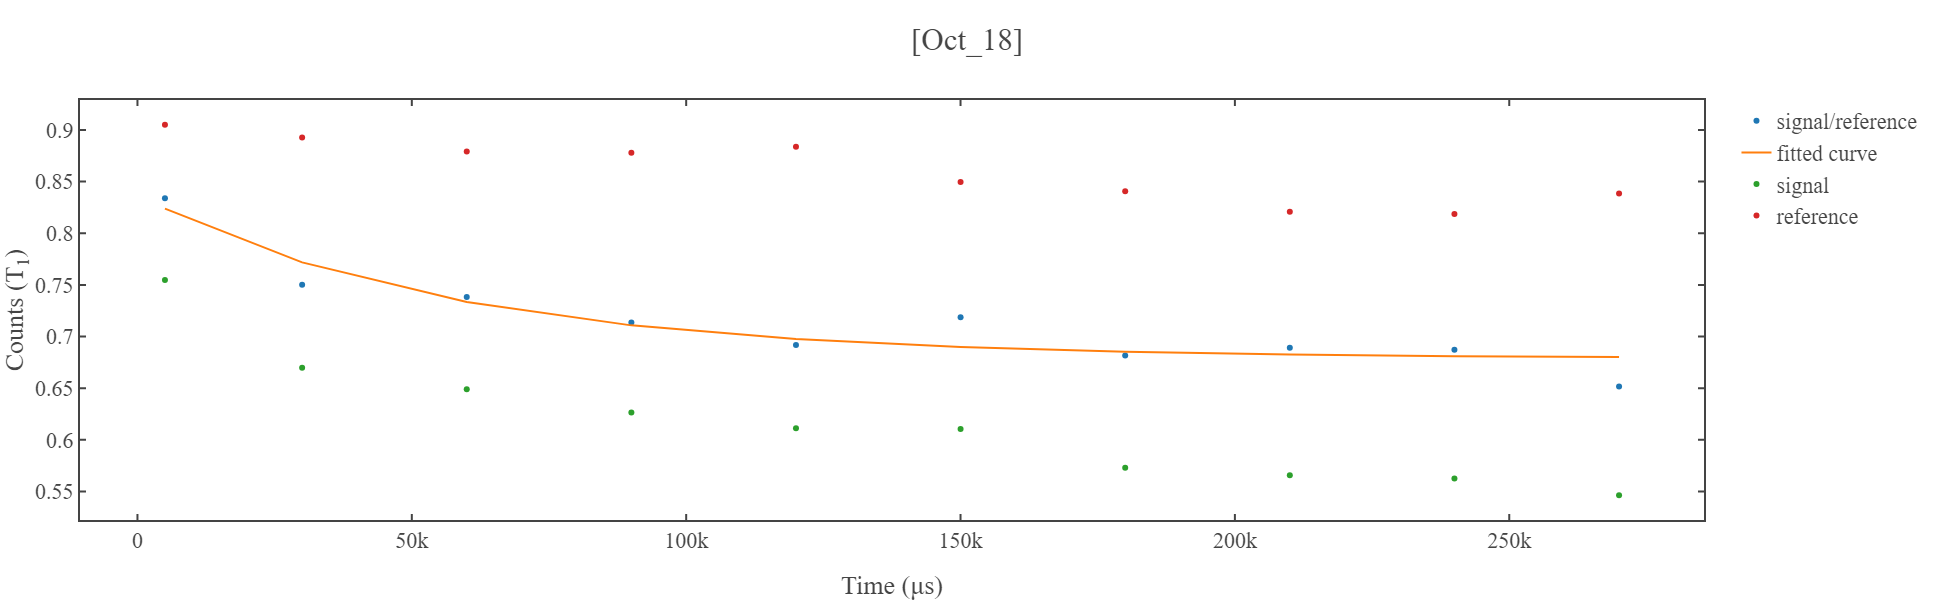

In [132]:
# loading the data 
load_data = dict(np.load(total_path))
time_axis,signal_photon,reference_samples,signal_samples = data_to_time_signal(load_data,samples,first=first_sig_ref)


x=time_axis[1:]
y=signal_photon[1:]
guess_parameters = np.array([0.7,1,0.5e6])  # input these paramters(serially) with your guess  
fitting_function = 'exp'   # y0+y_max*np.exp(-x/tau)
fitting_range = False   # for x-axis 

# fitting the data
x_fit,y_fit,coefficient,error_bars = fit_func(x,y,fit_range=fitting_range,func=fitting_function,guess_params=guess_parameters) 
if len(str(int(coefficient[2])))>7 or coefficient[2]<0:
    print('Fitted lifetime seems too long (more than 10ms) or negative.')
    print('If not expected for T1 exp, retry with increasing or decreasing the evolution time of the sequence.')
# plotting the data 
fig1 = simple_plot(x,y,show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='signal/reference')
fig2 = simple_plot(x_fit,y_fit,show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='lines',title=f'{date}',curve_name='fitted curve')
fig3 = simple_plot(x,signal_samples[1:],show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='signal')
fig4 = simple_plot(x,reference_samples[1:],show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='reference')

add_figures([fig1,fig2,fig3,fig4],show=True,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",title=f'[{date}]')

# Mardown cells to write specifications
> remember to change the below cells from code to markdown (see in the top).
>> Add calibrations, specifications and few reference plots.